# Part B - Predictive Modelling

In [1]:
# importing general libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ast import literal_eval
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
# loading the data
restaurant_data = pd.read_csv('data/zomato_df_final_data.csv')

## 1. Feature Engineering
Implement the feature engineering approaches to:
1. Perform data cleaning to remove/impute any records that are useless in the predictive task (such as NA, NaN, etc.)
2. Use proper label/feature encoding for each feature/column you consider making the data ready for the modelling step.

## 1. Perform data cleaning to remove/impute any records that are useless in the predictive task (such as NA, NaN, etc.)
Since the dataset is pretty small with only about 10500 rows, we will consider imputing the values rather than dropping

In [3]:
# Showing the percentage of Missing Data
restaurant_data.isna().sum()/restaurant_data.shape[0]*100

address           0.000000
cost              3.295238
cuisine           0.000000
lat               1.828571
link              0.000000
lng               1.828571
phone             0.000000
rating_number    31.580952
rating_text      31.580952
subzone           0.000000
title             0.000000
type              0.457143
votes            31.580952
groupon           0.000000
color             0.000000
cost_2            3.295238
cuisine_color     0.000000
dtype: float64

In [4]:
categorical = [var for var in restaurant_data.columns if restaurant_data[var].dtype=='O']
numerical_cols = [numerical for numerical in restaurant_data.columns if numerical not in categorical]
print(f'Categorical Variables: {categorical}')
print(f'Numerical Variables: {numerical_cols}')

Categorical Variables: ['address', 'cuisine', 'link', 'phone', 'rating_text', 'subzone', 'title', 'type', 'color', 'cuisine_color']
Numerical Variables: ['cost', 'lat', 'lng', 'rating_number', 'votes', 'groupon', 'cost_2']


### Cleaning the features


#### rating_number and rating_text
31.58% of rating_number is missing, so we will impute this variable first

Since the EDA showed normal distribution with mean of around 3.28, we will assume the dataset follows normal distribution. And impute the rating_number based on the global average.

In [5]:
# imputing the remaining rating number by global average
restaurant_data['rating_number'].fillna(restaurant_data['rating_number'].mean(), inplace=True)

In [6]:
print(f"Total Missing Values in rating_number : {restaurant_data['rating_number'].isna().sum()}")

Total Missing Values in rating_number : 0


The rating_number has been cleaned. Now imputing rating_text based on rating_number using the average rating for rating_text in the EDA

In [7]:
# based on the rating_number, imputing rating text using the average rating we got from the eda
def classify_rating(rating_number):
    if rating_number >= 4.61:
        return 'Excellent'
    elif rating_number >= 4.13:
        return 'Very Good'
    elif rating_number >= 3.66:
        return 'Good'
    elif rating_number >= 3.06:
        return 'Average'
    else:
        return 'Poor'

In [8]:
restaurant_data['rating_text'].fillna(restaurant_data['rating_number'].apply(classify_rating), inplace=True)
print(f"Total Missing Values in rating_text : {restaurant_data['rating_text'].isna().sum()}")

Total Missing Values in rating_text : 0


#### cost and cost_2

3.295238 % of the data in cost and cost_2 is na. Assuming that the similar rated restaurants are more likely to have similar cost.So, using the mean of cost and cost_2 from rating_text of restaurant to impute the data instead of global average for cost

In [9]:
restaurant_data['cost'] = restaurant_data.groupby('rating_text')['cost'].transform(lambda x: x.fillna(x.mean()))
restaurant_data['cost_2'] = restaurant_data.groupby('rating_text')['cost_2'].transform(lambda x: x.fillna(x.mean()))

In [10]:
print(f"Total Missing Values in cost : {restaurant_data['cost'].isna().sum()}")
print(f"Total Missing Values in cost_2 : {restaurant_data['cost_2'].isna().sum()}")

Total Missing Values in cost : 0
Total Missing Values in cost_2 : 0


The cost and cost_2 values are cleaned

In [11]:
# since only 0.45% of type is missing, we can safely remove the rows that have missing type
restaurant_data.dropna(subset=['type'], inplace=True)

In [12]:

print(f"Total Missing Values in cost : {restaurant_data['cost'].isna().sum()}")

Total Missing Values in cost : 0


In [13]:
# checking for strings hiding na
restaurant_data['type'].value_counts()

type
['Casual Dining']                    4854
['Café']                             2767
['Fast Food']                         557
['Food Court']                        480
['Pub']                               284
                                     ... 
['Club', 'Casual Dining']               1
['Dessert Parlour', 'Fast Food']        1
['Dessert Parlour', 'Food Court']       1
['Club', 'Pub']                         1
['Food Court', 'Beverage Shop']         1
Name: count, Length: 66, dtype: int64

There isnt any NA hiding in type in form of string, so we can consider type to be cleaned

#### votes
Imputing the votes based on mean obtained grouping by subzone and cuisine, and then imputing the remaining by global mean

In [14]:
restaurant_data['votes'] = restaurant_data.groupby(['subzone', 'cuisine'])['votes'].transform(lambda x: x.fillna(x.mean()))

In [15]:
restaurant_data['votes'].fillna(restaurant_data['votes'].mean(), inplace=True)

In [16]:
print(f"Total Missing Values in votes : {restaurant_data['votes'].isna().sum()}")

Total Missing Values in votes : 0


#### cuisine
cuisine is stored in the dataset as a string which appear to be in the form of list ['']

In [17]:

cuisine_count  = restaurant_data['cuisine'].apply(lambda x: len(x)).reset_index()
print(f'Number of Cuisine having string length <=4 :{sum(cuisine_count["cuisine"]<=4)}')

Number of Cuisine having string length <=4 :0


From this, we can conclude that cuisine doesnt have any hidden NA

In [18]:
# Showing the percentage of Missing Data
restaurant_data.isna().sum()/restaurant_data.shape[0]*100

address          0.000000
cost             0.000000
cuisine          0.000000
lat              1.836969
link             0.000000
lng              1.836969
phone            0.000000
rating_number    0.000000
rating_text      0.000000
subzone          0.000000
title            0.000000
type             0.000000
votes            0.000000
groupon          0.000000
color            0.000000
cost_2           0.000000
cuisine_color    0.000000
dtype: float64

Most of the data except lat and lng have been cleaned, since lat and lng are geographical values, we cant simply take mean and impute them. As lat and lng are less likely to be useful for regression or classification, we will leave them as it is and not use it.

In [19]:
# creating correlation matrix among the numerical variables
restaurant_data_numerical = restaurant_data[numerical_cols]

In [20]:
correlation_matrix = restaurant_data_numerical.corr()

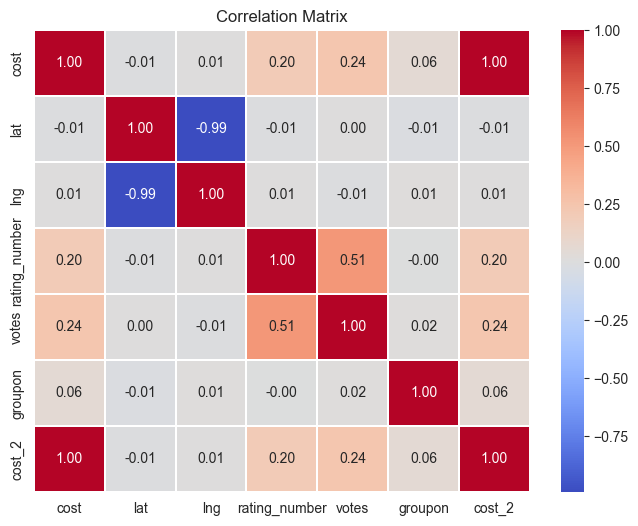

In [21]:
plt.figure(figsize=(8,6))  # You can specify the size of your plot here
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.05)
plt.title('Correlation Matrix')
plt.show()

From the correlation matrix, it can be seen only votes, cost_2, cost are somewhat related to rating_number which we will use in regression. We can also see cost_2 and cost are highly correlated, so to avoid multi collinearity, we will only include cost. So, the numerical columns that wont be included are : cost_2, lat, lng and groupon

In case of categorical variables, the following variables dont particularly provide help in prediction:
* address
* link
* phone
* title
* color
* cuisine_color
So, we will remove these columns as well

In [22]:
cols_to_remove = ['address','phone','title','color','cuisine_color','cost_2','lat','lng','groupon','link']
data_for_modeling = restaurant_data.drop(cols_to_remove, axis=1)

### 1.2  Use proper label/feature encoding for each feature/column you consider making the data ready for the modelling step.

type and cuisine seems to be list, but they are stored as string in the dataset, so we will convert them to list using `literal_eval`

In [23]:
data_for_modeling['type'] = data_for_modeling['type'].apply(literal_eval)
data_for_modeling['cuisine'] = data_for_modeling['cuisine'].apply(literal_eval)

In [24]:
data_for_modeling.head()

cost                              cuisine  rating_number rating_text  \
0   50.0   [Hot Pot, Korean BBQ, BBQ, Korean]            4.0   Very Good   
1   80.0  [Cafe, Coffee and Tea, Salad, Poké]            4.6   Excellent   
2  120.0                           [Japanese]            4.9   Excellent   
3  270.0                  [Modern Australian]            4.9   Excellent   
4   55.0                        [Thai, Salad]            4.5   Excellent   

                                 subzone                type   votes  
0                                    CBD     [Casual Dining]  1311.0  
1  The Grounds of Alexandria, Alexandria              [Café]  3236.0  
2                      The Star, Pyrmont       [Fine Dining]  1227.0  
3                          Circular Quay  [Fine Dining, Bar]   278.0  
4                              Chinatown     [Casual Dining]  2150.0

## Label Encoding

In [25]:
print(f"Number of unique subzones: {data_for_modeling['subzone'].nunique()}")

Number of unique subzones: 572


Since, there are 572 unique values for subzone, it isnt feasible to use One-Hot Encoder as it will increase the dimensionality by huge margin and using LabelEncoder for high dimensionality might imply an ordinal relationship that doesn't exist. So, we will use BinaryEncoder instead which will reduce dimensionality while retaining information.

In [26]:
import category_encoders as ce
subzone_encoder = ce.BinaryEncoder(cols=["subzone"])

In [27]:
data_for_modeling = subzone_encoder.fit_transform(data_for_modeling)

There are 134 unique cuisines, so using OneHotEncoder will introduce high dimensionality. For this purpose, we will create a new column `cuisine_numbers` which will store number of cuisines available in a restaurant

In [28]:
data_for_modeling['cuisine_numbers'] = data_for_modeling['cuisine'].apply(len)
data_for_modeling = data_for_modeling.drop(["cuisine"],axis=1)

Since there are only 15 unique types, we can use one hot encoding

In [29]:
# Since there are only 15 unique types, we can use one hot encoding
from sklearn.preprocessing import MultiLabelBinarizer


# reset index of original DataFrame
data_for_modeling.reset_index(drop=True, inplace=True)

# apply multilabel binarizer
mlb = MultiLabelBinarizer()
mlb = MultiLabelBinarizer()
one_hot = mlb.fit_transform(data_for_modeling['type'])
one_hot_df = pd.DataFrame(one_hot, columns=mlb.classes_)

data_for_modeling = pd.concat([data_for_modeling, one_hot_df], axis=1)
data_for_modeling = data_for_modeling.drop(["type"], axis=1)

In [30]:
# Normalizing the data so as to use in prediction
from sklearn.preprocessing import StandardScaler
# normalizing the numeric columns
cols_to_normalize = ["cost","cuisine_numbers","votes"]
scaler = StandardScaler()
data_for_modeling[cols_to_normalize] = scaler.fit_transform(data_for_modeling[cols_to_normalize] )

In [31]:
data_for_modeling

cost  rating_number rating_text  subzone_0  subzone_1  subzone_2  \
0     -0.041096       4.000000   Very Good          0          0          0   
1      1.054893       4.600000   Excellent          0          0          0   
2      2.516211       4.900000   Excellent          0          0          0   
3      7.996156       4.900000   Excellent          0          0          0   
4      0.141569       4.500000   Excellent          0          0          0   
...         ...            ...         ...        ...        ...        ...   
10447 -0.406426       3.283672     Average          0          0          0   
10448 -1.137085       3.283672     Average          0          0          1   
10449 -1.137085       3.283672     Average          0          0          1   
10450 -1.319750       3.283672     Average          0          1          0   
10451  0.324234       3.283672     Average          0          1          0   

       subzone_3  subzone_4  subzone_5  subzone_6  ...  Casual Dining  Club  \
0              0          0          0          0  ...              1     0   
1              0          0          0          0  ...              0     0   
2              0          0          0          0  ...              0     0   
3              0          0          0          0  ...              0     0   
4              0          0          0          0  ...              1     0   
...          ...        ...        ...        ...  ...            ...   ...   
10447          0          0          0          1  ...              1     0   
10448          0          1          0          1  ...              0     0   
10449          0          0          1          0  ...              0     0   
10450          1          1          0          0  ...              0     0   
10451          1          0          1          0  ...              1     0   

       Dessert Parlour  Fast Food  Fine Dining  Food Court  Food Stall  \
0                    0          0            0           0           0   
1                    0          0            0           0           0   
2                    0          0            1           0           0   
3                    0          0            1           0           0   
4                    0          0            0           0           0   
...                ...        ...          ...         ...         ...   
10447                0          0            0           0           0   
10448                0          0            0           0           0   
10449                0          0            0           1           0   
10450                0          0            0           1           0   
10451                0          0            0           0           0   

       Food Truck  Pub  Wine Bar  
0               0    0         0  
1               0    0         0  
2               0    0         0  
3               0    0         0  
4               0    0         0  
...           ...  ...       ...  
10447           0    0         0  
10448           0    0         0  
10449           0    0         0  
10450           0    0         0  
10451           0    0         0  

[10452 rows x 29 columns]

# 2. Regression

In [32]:
features = data_for_modeling.drop(["rating_number","rating_text"],axis=1)
target = data_for_modeling["rating_number"]

### 3.Build a linear regression model (model_regression_1) to predict the restaurants rating (numeric rating) from other features (columns) in the dataset. Please consider splitting the data into train (80%) and test (20%) sets.
Hint: please use sklearn.model_selection.train_test_split and set random_state=0  while splitting


In [33]:
features_train,features_test, target_train, target_test = train_test_split(features,target,test_size=0.2, random_state=0)

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [35]:
model_regression_1 = LinearRegression()
model_regression_1.fit(features_train, target_train)


LinearRegression()

In [36]:
y_pred_model_1 = model_regression_1.predict(features_test)
mse_model_1 = mean_squared_error(target_test, y_pred_model_1)
print(f"MSE for Model 1 : {mse_model_1}")

MSE for Model 1 : 0.10081976150438969


### 2.4 Build another linear regression model (model_regression_2) with using the Gradient Descent as the optimisation function.

In [37]:
class GradientDescentLinearRegression:
    def __init__(self, learning_rate, iterations):
        """
        Initializes the GradientDescentLinearRegression object.

        """
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.theta = None

    def add_intercept_term(self, X: np.ndarray):
        """
        Adds an intercept term to the input matrix.

        """
        return np.hstack((np.ones((X.shape[0], 1)), X))

    def fit(self, X: np.ndarray, y: np.ndarray):
        """
        Fits the model to the input data.
        """
        if X.shape[0] != y.shape[0]:
            raise ValueError("The number of rows in X must be equal to the number of elements in y")

        X = self.add_intercept_term(X)
        self.theta = np.zeros(X.shape[1])

        for _ in range(self.iterations):
            hypothesis = np.dot(X, self.theta)
            error = hypothesis - y
            gradient = np.dot(X.T, error) / X.shape[0]
            self.theta -= self.learning_rate * gradient

    def predict(self, X: np.ndarray):
        """
        Makes predictions on the input data.
        """
        if self.theta is None:
            raise ValueError("The model is not fitted yet. Call 'fit' with appropriate arguments before using this method.")

        X = self.add_intercept_term(X)
        return np.dot(X, self.theta)


In [38]:
model_regression_2 = GradientDescentLinearRegression(learning_rate=0.001, iterations=10000)
# Fit the model to the training data
model_regression_2.fit(features_train, target_train)

In [39]:
y_pred_model_2 = model_regression_2.predict(features_test)
mse_model_2 = mean_squared_error(target_test, y_pred_model_2)
print(f"MSE for Model 2 : {mse_model_2}")

MSE for Model 2 : 0.19261213898521157


## 2.5 Report the mean square error (MSE) on the test data for both models.

In [40]:
print(f"MSE for Model 1 : {mse_model_1}")
print(f"MSE for Model 2 : {mse_model_2}")

MSE for Model 1 : 0.10081976150438969
MSE for Model 2 : 0.19261213898521157


The MSE for Model 1 using LinearRegression was around 0.101, while MSE for Model 2 using Gradient Descent Optimization was around 0.193. This indicates that Model 1 fit better to the training data than Model 2 in terms of accuracy. Due to this, Model 1 might generalize better to unseen data as compared to Model 2.

## 3. Classification

### 3.6 Simplify the problem into binary classifications where class 1 contains ‘Poor’ and
‘Average’ records while class 2 contains ‘Good’, ‘Very Good’ and ‘Excellent’ records.

In [41]:
def create_binary_class(rating_text):
    if rating_text in ["Poor","Average"]:
        # class 1
        return 0
    else:
        # class 2
        return 1

In [42]:
data_for_modeling["rating_binary"] = data_for_modeling["rating_text"].apply(lambda x: create_binary_class(x))

In [43]:
data_for_modeling

cost  rating_number rating_text  subzone_0  subzone_1  subzone_2  \
0     -0.041096       4.000000   Very Good          0          0          0   
1      1.054893       4.600000   Excellent          0          0          0   
2      2.516211       4.900000   Excellent          0          0          0   
3      7.996156       4.900000   Excellent          0          0          0   
4      0.141569       4.500000   Excellent          0          0          0   
...         ...            ...         ...        ...        ...        ...   
10447 -0.406426       3.283672     Average          0          0          0   
10448 -1.137085       3.283672     Average          0          0          1   
10449 -1.137085       3.283672     Average          0          0          1   
10450 -1.319750       3.283672     Average          0          1          0   
10451  0.324234       3.283672     Average          0          1          0   

       subzone_3  subzone_4  subzone_5  subzone_6  ...  Club  Dessert Parlour  \
0              0          0          0          0  ...     0                0   
1              0          0          0          0  ...     0                0   
2              0          0          0          0  ...     0                0   
3              0          0          0          0  ...     0                0   
4              0          0          0          0  ...     0                0   
...          ...        ...        ...        ...  ...   ...              ...   
10447          0          0          0          1  ...     0                0   
10448          0          1          0          1  ...     0                0   
10449          0          0          1          0  ...     0                0   
10450          1          1          0          0  ...     0                0   
10451          1          0          1          0  ...     0                0   

       Fast Food  Fine Dining  Food Court  Food Stall  Food Truck  Pub  \
0              0            0           0           0           0    0   
1              0            0           0           0           0    0   
2              0            1           0           0           0    0   
3              0            1           0           0           0    0   
4              0            0           0           0           0    0   
...          ...          ...         ...         ...         ...  ...   
10447          0            0           0           0           0    0   
10448          0            0           0           0           0    0   
10449          0            0           1           0           0    0   
10450          0            0           1           0           0    0   
10451          0            0           0           0           0    0   

       Wine Bar  rating_binary  
0             0              1  
1             0              1  
2             0              1  
3             0              1  
4             0              1  
...         ...            ...  
10447         0              0  
10448         0              0  
10449         0              0  
10450         0              0  
10451         0              0  

[10452 rows x 30 columns]

# 3.7 Build a logistic regression model (model_classification_3) for the simplified data, where training data is 80% and the test data is 20%.
Hint: please use sklearn.model_selection.train_test_split and set random_state=0 while splitting

In [44]:

features = data_for_modeling.drop(["rating_binary","rating_text","rating_number"],axis=1)
target = data_for_modeling["rating_binary"]

In [45]:
features_train,features_test, target_train, target_test = train_test_split(features,target,test_size=0.2, random_state=0)

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report

In [47]:
model_classification_3 = LogisticRegression()


In [48]:
model_classification_3.fit(features_train,target_train)

C:\Users\niran\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [49]:
y_pred_model_3 = model_classification_3.predict(features_test)

In [50]:
model_3_conf_matrix = confusion_matrix(target_test, y_pred_model_3)

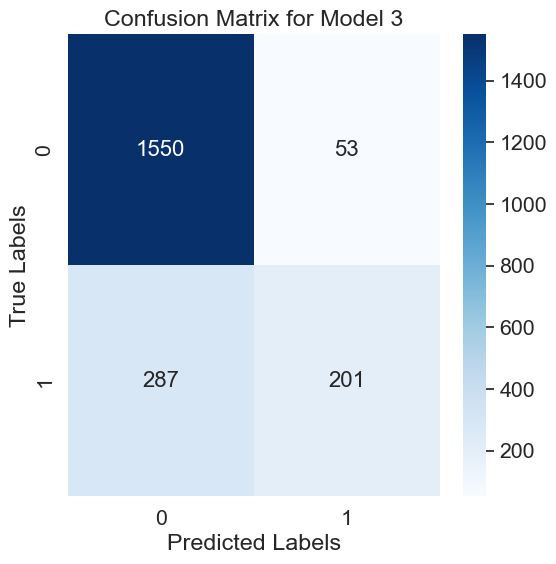

In [51]:
#Plotting the confusion matrix
plt.figure(figsize=(6, 6))
sns.set(font_scale=1.4) # for label size
sns.heatmap(model_3_conf_matrix, annot=True, fmt='g', cmap='Blues', annot_kws={"size": 16}) # font size

plt.title('Confusion Matrix for Model 3')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### 3.9 Draw your conclusions and observations about the performance of the model relevant to the classes’ distributions.

In [52]:
print(f"Accuracy: {accuracy_score(target_test, y_pred_model_3)}")
report = classification_report(target_test, y_pred_model_3, target_names=['Class 0', 'Class 1'])
print(report)

Accuracy: 0.8373983739837398
              precision    recall  f1-score   support

     Class 0       0.84      0.97      0.90      1603
     Class 1       0.79      0.41      0.54       488

    accuracy                           0.84      2091
   macro avg       0.82      0.69      0.72      2091
weighted avg       0.83      0.84      0.82      2091



The given report tells us that the model is about 83.74% correct when making predictions on 2091 different examples. It does really well at identifying Class 0, getting it right 84% of the time and missing very few. This results in a high score of 0.90 for Class 0. However, for Class 1, the model is good at avoiding false positives with a precision of 79%, but it often fails to identify the true Class 1 cases, catching them only 41% of the time, which results in a lower score of 0.54. The differences in scores between Class 0 and Class 1 might be because there are more examples of Class 0 in the data, making it hard for the model to learn to identify Class 1 correctly. So, in real-world use, this model would likely be more trustworthy when it says something is Class 0 than when it says something is Class 1.

## Bonus Repeat the previous classification taskusing threeother models of your choice

In [53]:
# function to train model and show evaluations on it
def train_model_and_evaluate(model, train_x, train_y, test_x, test_y):
    model_to_evaluate = model()
    model_to_evaluate.fit(train_x, train_y)
    model_pred = model_to_evaluate.predict(test_x)
    model_conf_matrix = confusion_matrix(test_y, model_pred)
    model_classification_report = classification_report(test_y, model_pred, target_names=['Class 0', 'Class 1'])
    print(f"Model: {type(model_to_evaluate).__name__}")
    print(f"Accuracy: {accuracy_score(test_y, model_pred)}")
    print(f"Confusion Matrix: \n {model_conf_matrix}")
    plt.figure(figsize=(6, 6))
    sns.set(font_scale=1.4) # for label size
    sns.heatmap(model_conf_matrix, annot=True, fmt='g', cmap='Blues', annot_kws={"size": 16}) # font size

    plt.title('Confusion Matrix for Model 3')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()
    print(f"Classification Report: \n {model_classification_report}")

In [54]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

### KNeighborsClassifier

Model: KNeighborsClassifier
Accuracy: 0.812051649928264
Confusion Matrix: 
 [[1503  100]
 [ 293  195]]


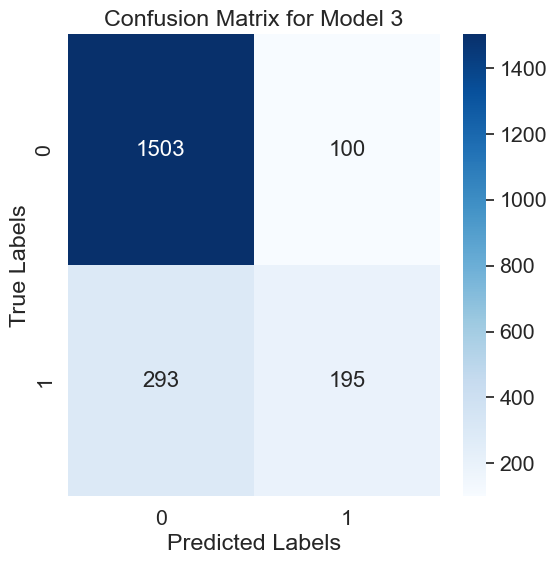

Classification Report: 
               precision    recall  f1-score   support

     Class 0       0.84      0.94      0.88      1603
     Class 1       0.66      0.40      0.50       488

    accuracy                           0.81      2091
   macro avg       0.75      0.67      0.69      2091
weighted avg       0.80      0.81      0.79      2091



In [55]:
train_model_and_evaluate(KNeighborsClassifier,features_train,target_train,features_test,target_test)

### SVC

Model: SVC
Accuracy: 0.8388330942132951
Confusion Matrix: 
 [[1554   49]
 [ 288  200]]


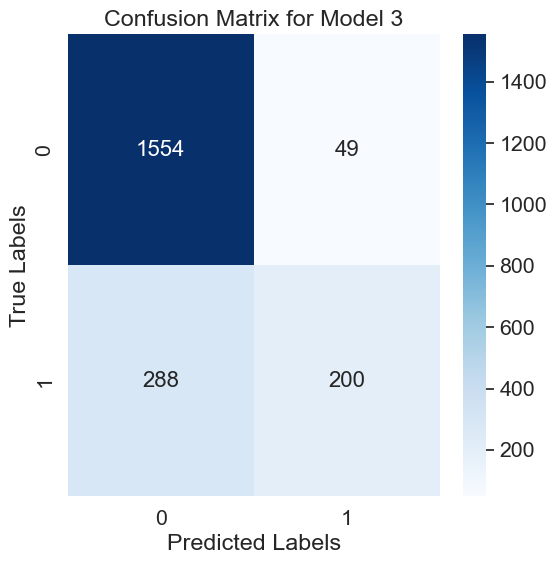

Classification Report: 
               precision    recall  f1-score   support

     Class 0       0.84      0.97      0.90      1603
     Class 1       0.80      0.41      0.54       488

    accuracy                           0.84      2091
   macro avg       0.82      0.69      0.72      2091
weighted avg       0.83      0.84      0.82      2091



In [56]:
train_model_and_evaluate(SVC,features_train,target_train,features_test,target_test)

### RandomForest

Model: RandomForestClassifier
Accuracy: 0.8775705404112865
Confusion Matrix: 
 [[1516   87]
 [ 169  319]]


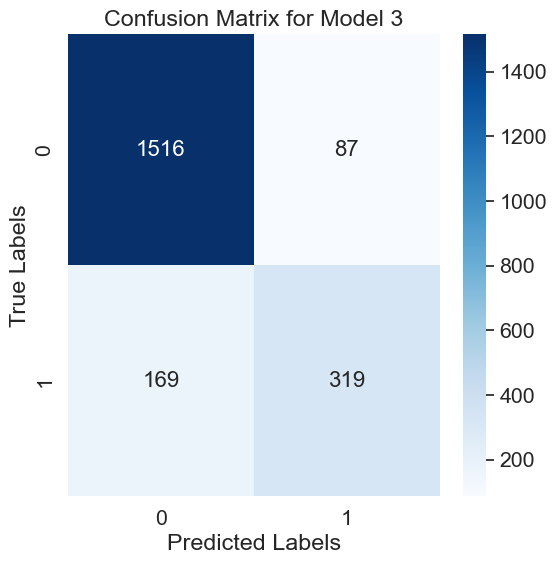

Classification Report: 
               precision    recall  f1-score   support

     Class 0       0.90      0.95      0.92      1603
     Class 1       0.79      0.65      0.71       488

    accuracy                           0.88      2091
   macro avg       0.84      0.80      0.82      2091
weighted avg       0.87      0.88      0.87      2091



In [57]:
train_model_and_evaluate(RandomForestClassifier,features_train,target_train,features_test,target_test)